<a href="https://colab.research.google.com/github/romenlaw/RL-playground/blob/main/rl_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [501]:
!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

  Cloning https://github.com/mimoralea/gym-walk to /tmp/pip-install-wffrcjrg/gym-walk_374f5f425089456f8426c27b0f4e2c43
  Running command git clone --filter=blob:none --quiet https://github.com/mimoralea/gym-walk /tmp/pip-install-wffrcjrg/gym-walk_374f5f425089456f8426c27b0f4e2c43
  Resolved https://github.com/mimoralea/gym-walk to commit 5999016267d6de2f5a63307fb00dfd63de319ac1
  Preparing metadata (setup.py) ... done


In [502]:
import gym, gym_walk
import warnings

# Ignore all DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)

# MDP Concepts / Foundation
Markov Decision Process:
* Partially-Observable Markov Decision Process (POMDP): When the agent cannot fully observe the environment state.
* Factored Markov Decision Process (FMDP): Allows the representation of the transition and reward function more compactly so that we can represent very large MDPs.
* Continuous [Time|Action|State] Markov Decision Process: When either time, action, state or any combination of them are continuous.
* Relational Markov Decision Process (RMDP): Allows the combination of probabilistic and relational knowledge.
* Semi-Markov Decision Process (SMDP): Allows the inclusion of abstract actions that can take multiple time steps to complete.
* Multi-Agent Markov Decision Process (MMDP): Allows the inclusion of multiple agents in the same environment.
* Decentralized Markov Decision Process (Dec-MDP): Allows for multiple agents to collaborate and maximize a common reward.

$MDP(\mathcal S,\mathcal A,\mathcal T,\mathcal R, \mathcal S_{\theta}, \gamma, \mathcal H)$

$POMDP(\mathcal S,\mathcal A,\mathcal T,\mathcal R, \mathcal S_{\theta}, \gamma, \mathcal H, \mathcal O, \mathcal E)$

$\mathcal S$ is state space,
$\mathcal A$ is action space,
$\mathcal T$ is transition function,
$\mathcal R$ is reward signal,
$\mathcal S_{\theta}$ is initial states distribution,
$\gamma$ is discount factor,
$\mathcal H$ is horizon,
$\mathcal O$ is observation space,
$\mathcal E$ is emission probability that defines the prob of showing an observation $o_t$ at given state $s_t$.



## Environment
* The outer dict keys are States.
* The inner dict keys are Actions.

{0: {0: [(0.8, 0, 0.0, True), ...], ...

In State 0, Action 0 has 80% chance to transit into State 0, which has Reward 0.0 and is a terminal state...

In [503]:
P = gym.make('BanditSlipperyWalk-v0').env.P
print(f"this environment has {len(P)} states")
print(f"state 1 has transition rules: Action: [(prob, next_state, reward, next_state_is_terminal), (...), ...]: \n", P[1])
P

this environment has 3 states
state 1 has transition rules: Action: [(prob, next_state, reward, next_state_is_terminal), (...), ...]: 
 {0: [(0.8, 0, 0.0, True), (0.0, 1, 0.0, False), (0.2, 2, 1.0, True)], 1: [(0.8, 2, 1.0, True), (0.0, 1, 0.0, False), (0.2, 0, 0.0, True)]}


{0: {0: [(0.8, 0, 0.0, True), (0.0, 0, 0.0, True), (0.2, 0, 0.0, True)],
  1: [(0.8, 0, 0.0, True), (0.0, 0, 0.0, True), (0.2, 0, 0.0, True)]},
 1: {0: [(0.8, 0, 0.0, True), (0.0, 1, 0.0, False), (0.2, 2, 1.0, True)],
  1: [(0.8, 2, 1.0, True), (0.0, 1, 0.0, False), (0.2, 0, 0.0, True)]},
 2: {0: [(0.8, 2, 0.0, True), (0.0, 2, 0.0, True), (0.2, 2, 0.0, True)],
  1: [(0.8, 2, 0.0, True), (0.0, 2, 0.0, True), (0.2, 2, 0.0, True)]}}

In [504]:
P = gym.make('BanditWalk-v0').env.P
P

{0: {0: [(1.0, 0, 0.0, True), (0.0, 0, 0.0, True), (0.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True), (0.0, 0, 0.0, True), (0.0, 0, 0.0, True)]},
 1: {0: [(1.0, 0, 0.0, True), (0.0, 1, 0.0, False), (0.0, 2, 1.0, True)],
  1: [(1.0, 2, 1.0, True), (0.0, 1, 0.0, False), (0.0, 0, 0.0, True)]},
 2: {0: [(1.0, 2, 0.0, True), (0.0, 2, 0.0, True), (0.0, 2, 0.0, True)],
  1: [(1.0, 2, 0.0, True), (0.0, 2, 0.0, True), (0.0, 2, 0.0, True)]}}

In [505]:
P = gym.make('FrozenLake-v1').env.P
len(P),P

(16,
 {0: {0: [(0.3333333333333333, 0, 0.0, False),
    (0.3333333333333333, 0, 0.0, False),
    (0.3333333333333333, 4, 0.0, False)],
   1: [(0.3333333333333333, 0, 0.0, False),
    (0.3333333333333333, 4, 0.0, False),
    (0.3333333333333333, 1, 0.0, False)],
   2: [(0.3333333333333333, 4, 0.0, False),
    (0.3333333333333333, 1, 0.0, False),
    (0.3333333333333333, 0, 0.0, False)],
   3: [(0.3333333333333333, 1, 0.0, False),
    (0.3333333333333333, 0, 0.0, False),
    (0.3333333333333333, 0, 0.0, False)]},
  1: {0: [(0.3333333333333333, 1, 0.0, False),
    (0.3333333333333333, 0, 0.0, False),
    (0.3333333333333333, 5, 0.0, True)],
   1: [(0.3333333333333333, 0, 0.0, False),
    (0.3333333333333333, 5, 0.0, True),
    (0.3333333333333333, 2, 0.0, False)],
   2: [(0.3333333333333333, 5, 0.0, True),
    (0.3333333333333333, 2, 0.0, False),
    (0.3333333333333333, 1, 0.0, False)],
   3: [(0.3333333333333333, 2, 0.0, False),
    (0.3333333333333333, 1, 0.0, False),
    (0.3333333333

## Return
The Return is the sum of Rewards encountered from step t until the final step T:
$$G_t = R_{t+1} + R_{t+2} + R_{t+3} + ...+ R_T$$

With discount factor:
$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2R_{t+3} + ...+ \gamma^{T-1}R_T$$
$$G_t = \sum_{k=0}^\infty \gamma^kR_{t+1+k}$$

In recursive form:
$$G_t = R_{t+1} + \gamma G_{t+1}$$

## State-Value Function V
AKA Value Function, V-function, $V^\pi(s)$...

Value of state s when following a policy π:
$$v_\pi(s)=\mathbb{E}_\pi[G_t|S_t=s]$$
Value of a State s under Policy \pi is the Expectation over \pi of Returns at time step t given you select State s at time step t.
Use recursive form of Return:
$$v_\pi(s)=\mathbb{E}_\pi[R_t+\gamma G_{t+1}|S_t=s]$$

**Bellman equation**: it tells us how to find the value of states
$$v_\pi(s)=\sum_a \pi(a|s)\sum_{s', r}\{p(s',r|s,a)[r+\gamma v_\pi(s')]\}, \forall s \in S$$

* We get the action (or actions, if policy is stocastic) prescribed for state s. And do a weighted sum...
* We also weight the sum over the probability of next states and rewards.
* We add the reward and the discounted value of the landing states, weight that by the probabilities.
* do this for all states in the state space



## Action-Value Function Q
What to expect from here if I do this?

AKA Q-function. or $Q^\pi(s,a)$: gives us the expected Return if agent follows policy π after taking action a in state s.

$$q_\pi(s, a)=\mathbb{E}_\pi[G_t|S_t=s, A_t=a]$$
The value of Action a in State s is the expectation of Returns given we select action a in state s and follow policy π thereafter.

In recursive form:
$$q_\pi(s,a) =  \mathbb{E}_\pi[R_t+\gamma G_{t+1}|S_t=s, A_t=a]$$

The Bellman equation for action-values:
$$q_\pi(s,a)=\sum_{s',r}\{p(s',r|s,a)[r+\gamma v_\pi(s')]\}, \forall s \in S, \forall a \in A(s)$$


## Action-Advantage Function
i.e. how much better if I do this (comparing to taking the default action under policy π?

The advantage of action a in state s under a policy π:
$$a_\pi(s,a)=q_\pi(s,a)-v_\pi(s)$$


# Q-Learning
Downside of Q-learning:
* actions space is discrete and small
* cannot handle continuous action spaces
* policy is deterministically calculated from Q-function by maximising rewards -> cannot learn stochastic policies

## Policy Evaluation -> V

The policy evaluation equation
$$v_{k+1}(s)=\sum_a \pi(a|s)\sum_{s', a}p(s',r|s,a)[r+\gamma v_k(s')]$$

For a deterministic policy (e.g. we always move left), $\sum_a \pi(a|s)=1$

In [506]:
import numpy as np

def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
  prev_V = np.zeros(len(P)) # initialise value for each state to 0
  while True:
    V = np.zeros(len(P))
    for s in range(len(P)):
      # example of P[s]pi[s]: [(0.8, 0, 0.0, True), (0.0, 1, 0.0, False), (0.2, 2, 1.0, True)]
      for (prob, next_state, reward, done) in P[s][pi[s]]:
        # multiply by not done s.t. V(s)=0 if s is terminal state
        V[s] += prob * (reward + gamma * prev_V[next_state] * (not done) )
    # stop the while loop if values have converged
    if np.max(np.abs(prev_V - V)) < theta:
      break

    prev_V = V.copy()
  return V

### Evaluate SWF
Apply the above on Slippery Walk Five environment, using a policy of 'always left'.
```
 _________________________________
| H 0 | 1 | 2 | S 3 | 4 | 5 | G 6 |
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
There are 7 states in this env, H=hole, G=Goal, S=Start

In [507]:
P = gym.make('SlipperyWalkFive-v0').env.P
len(P),P

(7,
 {0: {0: [(0.5000000000000001, 0, 0.0, True),
    (0.3333333333333333, 0, 0.0, True),
    (0.16666666666666666, 0, 0.0, True)],
   1: [(0.5000000000000001, 0, 0.0, True),
    (0.3333333333333333, 0, 0.0, True),
    (0.16666666666666666, 0, 0.0, True)]},
  1: {0: [(0.5000000000000001, 0, 0.0, True),
    (0.3333333333333333, 1, 0.0, False),
    (0.16666666666666666, 2, 0.0, False)],
   1: [(0.5000000000000001, 2, 0.0, False),
    (0.3333333333333333, 1, 0.0, False),
    (0.16666666666666666, 0, 0.0, True)]},
  2: {0: [(0.5000000000000001, 1, 0.0, False),
    (0.3333333333333333, 2, 0.0, False),
    (0.16666666666666666, 3, 0.0, False)],
   1: [(0.5000000000000001, 3, 0.0, False),
    (0.3333333333333333, 2, 0.0, False),
    (0.16666666666666666, 1, 0.0, False)]},
  3: {0: [(0.5000000000000001, 2, 0.0, False),
    (0.3333333333333333, 3, 0.0, False),
    (0.16666666666666666, 4, 0.0, False)],
   1: [(0.5000000000000001, 4, 0.0, False),
    (0.3333333333333333, 3, 0.0, False),
    (0.1

In [508]:
# build the always-left policy
LEFT=0
RIGHT=1
n_states=len(P)
pi_always_left={}
for state in range(n_states): # ignore states 0 and 6 since they are terminal
  pi_always_left[state] = LEFT

In [509]:
pi_always_left

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

In [510]:
V_pi_always_left = policy_evaluation(pi_always_left, P)

In [511]:
V_pi_always_left

array([0.        , 0.00274725, 0.01098901, 0.03571429, 0.10989011,
       0.33241758, 0.        ])

### Evaluate FL
Frozen Lake: 16 states, 4 actions (L, D, R, U)
We will evaluate 3 policies: random, eager, careful


In [512]:
P = gym.make('FrozenLake-v1').env.P;
n_states = len(P)
# actions
LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3
decode_action = lambda i: ['L', 'D', 'R', 'U'][i]
# I will use UP for holes since it's easier to type
pi_random={
    0:RIGHT, 1:LEFT, 2:DOWN, 3:UP,
    4:LEFT, 5:UP, 6:RIGHT, 7:UP,
    8:UP, 9:DOWN, 10:UP, 11:UP,
    12:UP, 13:RIGHT, 14:DOWN, 15:UP
    }

In [513]:
V_random=policy_evaluation(pi_random, P, 0.99) ;
print("Random Policy value at START: %.4f" % V_random[0]);
V_random

Random Policy value at START: 0.0955


array([0.09554433, 0.04705915, 0.0470064 , 0.04562386, 0.1469248 ,
       0.        , 0.04976062, 0.        , 0.20275753, 0.26473443,
       0.10378337, 0.        , 0.        , 0.49568466, 0.74165563,
       0.        ])

In [514]:
import random
pi_true_random = {s:random.randint(0, 3) for s in range(n_states)}
print("random policy: ", pi_true_random)
V_true_random = policy_evaluation(pi_true_random, P, 0.99)
print("True random Policy value at START: %.4f" % V_true_random[0])
V_true_random

random policy:  {0: 2, 1: 3, 2: 1, 3: 3, 4: 1, 5: 3, 6: 0, 7: 1, 8: 0, 9: 3, 10: 1, 11: 1, 12: 3, 13: 1, 14: 1, 15: 0}
True random Policy value at START: 0.0238


array([0.02381959, 0.04836099, 0.07436787, 0.07218058, 0.        ,
       0.        , 0.10481561, 0.        , 0.        , 0.08027421,
       0.2432552 , 0.        , 0.        , 0.32352941, 0.65686275,
       0.        ])

In [515]:
pi_eager = {
    0:RIGHT, 1:RIGHT, 2:DOWN, 3: LEFT,
    4:DOWN, 5:UP, 6: DOWN, 7:UP,
    8:RIGHT, 9:RIGHT, 10:DOWN, 11:UP,
    12:UP, 13:RIGHT, 14:RIGHT, 15:UP
}
V_eager=policy_evaluation(pi_eager, P, 0.99) ;
print("Eager Policy value at START: %.4f" % V_eager[0]);
V_eager

Eager Policy value at START: 0.0342


array([0.03416037, 0.02305118, 0.04680089, 0.02305118, 0.04630471,
       0.        , 0.09571851, 0.        , 0.0940126 , 0.23858195,
       0.29005609, 0.        , 0.        , 0.43291953, 0.64037588,
       0.        ])

In [516]:
pi_careful = {
    0:LEFT, 1:UP, 2:UP, 3: UP,
    4:LEFT, 5:UP, 6: UP, 7:UP,
    8:UP, 9:DOWN, 10:LEFT, 11:UP,
    12:UP, 13:RIGHT, 14:RIGHT, 15:UP
}
V_careful=policy_evaluation(pi_careful, P, 0.99) ;
print("Careful Policy value at START: %.4f" % V_careful[0]);
V_careful

Careful Policy value at START: 0.4079


array([0.4079433 , 0.3754127 , 0.35425824, 0.34383888, 0.42030522,
       0.        , 0.11690522, 0.        , 0.44540366, 0.48399918,
       0.43282831, 0.        , 0.        , 0.58843221, 0.71069653,
       0.        ])

## Policy Improvement -> π
To improve a policy, we use a state-value function and an MDP to get a one-step lookahead and determine which of the actions lead to the highest value. This is policy improvement equation:
$$\pi'(s)=arg\max_{a}\sum_{s',r}p(s',r|s,a)[r+\gamma v_\pi(s')]$$

We obtain a new policy π' by taking the highest-valued action. How do we get the highest-valued action: by calculating for each action, the weighted sum of all rewards and values of all possible next states.

Notice that this is simply using the action with the highest-valued Q-function.

Downside of Q-learning:

* actions space is discrete and small
* cannot handle continuous action spaces
* policy is deterministically calculated from Q-function by maximising rewards -> cannot learn stochastic policies



In [517]:
np.argmax([1,2,2,1]), np.argmax([1,2,1,2])

(1, 1)

In [518]:
def policy_improvement(V, P, gamma=1.0):
  n_states = len(P)
  n_actions = len(P[0])
  # initialise Q-function to zeros
  Q = np.zeros((n_states, n_actions), dtype=np.float64)
  for s in range(n_states):
    for a in range(n_actions):
      for prob, next_state, reward, done in P[s][a]:
        Q[s,a] += prob * (reward + gamma * V[next_state] * (not done))
  print("Q-function: \n", Q)
  new_pi = {s:a for s, a in enumerate( np.argmax(Q, axis=1) )}
  #new_pi = lambda s: {s:a for s, a in enumerate( np.argmax(Q, axis=1) )}[s]

  return new_pi

In [519]:
new_pi_careful = policy_improvement(V_careful, P, gamma=0.99)

Q-function: 
 [[0.4079433  0.3972082  0.3972082  0.39312877]
 [0.25850748 0.25152651 0.24079141 0.3754127 ]
 [0.27937013 0.27593174 0.26895077 0.35425824]
 [0.23037205 0.23037205 0.22693366 0.34383888]
 [0.42030522 0.28568393 0.2816045  0.27332201]
 [0.         0.         0.         0.        ]
 [0.25973856 0.14283334 0.25973856 0.11690522]
 [0.         0.         0.         0.        ]
 [0.28568393 0.30670294 0.29842045 0.44540366]
 [0.34116584 0.48399918 0.33701597 0.28981655]
 [0.43282831 0.39424958 0.27310858 0.19829845]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.35390236 0.42871248 0.58843221 0.39424958]
 [0.57154583 0.76204582 0.71069653 0.6703493 ]
 [0.         0.         0.         0.        ]]


In [520]:
print(new_pi_careful)
print({s:decode_action(new_pi_careful[s]) for s in range(n_states)})

{0: 0, 1: 3, 2: 3, 3: 3, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 1, 10: 0, 11: 0, 12: 0, 13: 2, 14: 1, 15: 0}
{0: 'L', 1: 'U', 2: 'U', 3: 'U', 4: 'L', 5: 'L', 6: 'L', 7: 'L', 8: 'U', 9: 'D', 10: 'L', 11: 'L', 12: 'L', 13: 'R', 14: 'D', 15: 'L'}


In [521]:
d1={'a': 1, 'b': 2, 'c': 3}
d2=d1.copy()
#d2['c']=4
d2==d1, d1==d2

(True, True)

## Policy Iteration -> V, π*
Policy iteration is guaranteed to converge to optimal policy. We need to make sure if there is a tie in action-value function, we need to have a way to deterministically choose an action (not randomly). The np.argmax() (used in policy_improvement) works deterministically - it uses the index of the first found element.

In [522]:
import random

def policy_iteration(V, P, gamma=1.0, theta=1e-10):
  n_states = len(P)
  n_actions = len(P[0])
  # initialise policy to random actions.
  pi = {s:random.randint(0, n_actions-1) for s in range(n_states)}

  while True:
    old_pi = pi.copy() # no nested dict, no shallow copy only
    print("current Pi: ", [decode_action(a) for s, a in pi.items()])
    V = policy_evaluation(pi, P, gamma, theta)
    print("current V: ", V)
    pi = policy_improvement(V, P, gamma)
    if old_pi == pi:
      break # stop improving if converged

  return V, pi

In [523]:
# try it with a random V
V, pi = policy_iteration(V_true_random, P, 0.99)

current Pi:  ['R', 'R', 'R', 'D', 'D', 'R', 'U', 'U', 'R', 'R', 'D', 'U', 'U', 'R', 'U', 'U']
current V:  [0.01892081 0.         0.         0.         0.03841498 0.
 0.         0.         0.07799404 0.19793061 0.2406342  0.
 0.         0.35915553 0.53126394 0.        ]
Q-function: 
 [[0.02516468 0.01892081 0.01892081 0.01248773]
 [0.00624387 0.00624387 0.         0.00624387]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.04465884 0.03841498 0.0319819  0.01892081]
 [0.         0.         0.         0.        ]
 [0.07940929 0.07940929 0.07940929 0.        ]
 [0.         0.         0.         0.        ]
 [0.03841498 0.09105514 0.07799404 0.10373208]
 [0.14425936 0.22366865 0.19793061 0.10514732]
 [0.2406342  0.2406342  0.1753171  0.0653171 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.18383843 0.29383843 0.35915553 0.2406342 ]
 [0.37324771 0.62717176 0.58805972 0.53126394]
 [0.       

In [524]:
print(V)
print([decode_action(a) for s, a in pi.items()])

[0.54202593 0.49880319 0.47069569 0.4568517  0.55845096 0.
 0.35834807 0.         0.59179874 0.64307982 0.61520756 0.
 0.         0.74172044 0.86283743 0.        ]
['L', 'U', 'U', 'U', 'L', 'L', 'L', 'L', 'U', 'D', 'L', 'L', 'L', 'R', 'D', 'L']


## Value Iteration (VI) -> V, π*
Improving behaviours early: only do one-step for policy evaluation, then do policy improvement.

We can merge the truncated policy evaluation step and a policy improvement into the same equation:
$$v_{k+1}(s) = \max_a \sum_{s', r}p(s',r|s,a)[r+\gamma v_k(s')]$$

Note that we don't deal with policies at all. It does it through value functions only, hence VI.

In [525]:
import numpy as np

def value_iteration(P, gamma=1.0, theta=1e-10):
  n_states = len(P)
  n_actions = len(P[0])
  # initialise V to zeros
  V = np.zeros(n_states, dtype=np.float64)

  while True:
    # initialise Q-function to zeros
    Q = np.zeros((n_states, n_actions), dtype=np.float64)
    for s in range(n_states):
      for a in range(n_actions):
        for prob, next_state, reward, done in P[s][a]:
          Q[s,a] += prob * (reward + gamma * V[next_state] * (not done))
    if np.max( np.abs(V - np.max(Q, axis=1)) ) < theta:
      break; # if the action-advantage function converged, break

    V = np.max(Q, axis=1) # combination of policy eval and improv
  pi = {s:a for s, a in enumerate( np.argmax(Q, axis=1) )}

  return V, pi


In [526]:
V2,pi2=value_iteration(P, 0.99)
print(V2)
print([decode_action(a) for s, a in pi2.items()])

[0.54202593 0.49880318 0.47069569 0.4568517  0.55845096 0.
 0.35834807 0.         0.59179874 0.64307982 0.61520756 0.
 0.         0.74172044 0.86283743 0.        ]
['L', 'U', 'U', 'U', 'L', 'L', 'L', 'L', 'U', 'D', 'L', 'L', 'L', 'R', 'D', 'L']


In [527]:
print(V)
print([decode_action(a) for s, a in pi.items()])

[0.54202593 0.49880319 0.47069569 0.4568517  0.55845096 0.
 0.35834807 0.         0.59179874 0.64307982 0.61520756 0.
 0.         0.74172044 0.86283743 0.        ]
['L', 'U', 'U', 'U', 'L', 'L', 'L', 'L', 'U', 'D', 'L', 'L', 'L', 'R', 'D', 'L']


In [528]:
import math
pi==pi2, all(math.isclose(v1, v2, abs_tol=1e-10) for v1, v2 in zip(V, V2))

(True, True)

# Multi-Armed Bandit (MAB)

MABs are MDPs with
* single non-terminal state, and
* single timestep per episode (horizon=1)

$$MAB = MDP(\mathcal S=\{s\}, \mathcal A, \mathcal T, \mathcal R, \mathcal S_\theta=\{s\}, \gamma=1, \mathcal H=1)$$

Q-function of action a|s of MAB:
$$q(a) = \mathbb E [R_t|A_t=a]$$

The best we can do in a MAB is represented by the optimal V-function, or selecting the action that maximises the Q-function:
$$v^*=q(a_*)=\max_{a \in A}q(a)$$

The optimal action is the action that maximises the optimal Q-function and optimal V-function (only 1 state)
$$a_*=arg\max_{a \in A}q(a)$$

## Total Regret

The Total Regret equation:
$$\mathcal T = \sum_{e=1}^E \mathbb E[v_*-q_*(A_e)]$$
To calculate the total regret: add up for all the episodes: the difference between the optimal value of the MAB and the *true value of the action selected*.

## Base Class for Strategies

Here is a base class to be inherited by actual strategies.

In [574]:
import numpy as np
from tqdm import tqdm

# base class for all the strategies below.
class StrategyBase:
  def __init__(self, name, env, n_episodes=5000):
    assert isinstance(n_episodes, int), "n_episodes must be integer"
    assert n_episodes>0, "n_episodes must be greater than 0"
    self.name = name
    self.env = env
    self.n_episodes = n_episodes

    self.Q = np.zeros((env.action_space.n))
    self.N = np.zeros((env.action_space.n))

    # for monitoring and stats only, not necessary for the algorithm
    self.Qe = np.empty((n_episodes, env.action_space.n))
    self.returns = np.empty(n_episodes)
    self.actions = np.empty(n_episodes)

  def update(self, e, strat='explore'):
    """strat is either 'explore' or 'exploit'
    """
    self.env.reset()
    if strat=='exploit':
      action = np.argmax(self.Q)
    else:
      action = np.random.randint(len(self.Q))

    _, reward, _, _ = env.step(action)
    self.N[action] += 1
    self.Q[action] = self.Q[action] + (reward - self.Q[action]) / self.N[action]

    self.Qe[e] = self.Q
    self.returns[e] = reward
    self.actions[e] = action

  # to be implemented by child classes
  def run(self):
    pass

  def __repr__(self):
    return self.name

  def total_regret(self):
    V, _ = value_iteration(self.env.P)
    v = max(V) # for bandit, there is only one non-terminal state, in this env, its state 1
    tr=0
    trs = np.empty(self.n_episodes)
    for e in range(self.n_episodes):
      tr += v - self.Qe[e][int(self.actions[e])]
      trs[e] = tr
    return trs

## Pure Exploitation Strategy
This baseline is called *greedy strategy*, or *pure exploitation strategy*. The greedy actionselection
approach consists of always selecting the action with the highest estimated value.
While there is a chance for the very first action, we choose to be the best overall action, the likelihood of this lucky coincidence decreases as the number of available actions increases.

In [575]:
class PureExploitation(StrategyBase):
  def __init__(self, env, n_episodes=5000):
    super().__init__("Pure Exploitation", env, n_episodes)

  def run(self):
    for e in tqdm(range(self.n_episodes), desc=f"Episodes for {self.name}", leave=True):
      self.update(e, strat='exploit')

## Pure Exploration Strategy
This is another fundamental baseline which we can call a *random strategy* or a *pure exploration strategy*. This is simply an approach to action selection with no exploitation at all. The sole goal of the agent is to gain information.

In [576]:
class PureExploration(StrategyBase):
  def __init__(self, env, n_episodes=5000):
    super().__init__("Pure Exploration", env, n_episodes)

  def run(self):
    for e in tqdm(range(self.n_episodes), desc=f"Episodes for {self.name}", leave=True):
      self.update(e, strat='explore')

## ϵ-Greedy

Almost always greedy, just sometimes random.

In [577]:
class EpsilonGreedy(StrategyBase):
  def __init__(self, env, epsilon=0.01, n_episodes=5000):
    super().__init__(f'Epsilon-Greedy {epsilon}', env, n_episodes)
    self.epsilon = epsilon

  def run(self):
    for e in tqdm(range(self.n_episodes), desc=f"Episodes for {self.name}", leave=True):
      if np.random.random() > epsilon:
        self.update(e, 'exploit')
      else:
        self.update(e, 'explore')


## Decaying ϵ-Greedy
First maximise exploration, then exploitation.
**Note** that in these algorithms, the `decay_ratio` parameter determines the number of episodes that will explore instead of exploit - e.g if `decay_ratio=0.05`, it means the first 5% of the episodes will be used to to decay the epsilon from `init_epsilon` to `min_epsilon`.

In [578]:
# Linear decaying epsilon greedy
class LinearDecayEpsilonGreedy(StrategyBase):
  def __init__(self,
               env,
               init_epsilon=1.0,
               min_epsilon=0.01,
               decay_ratio=0.05, # the ratio of episodes that will decay eps
               n_episodes=5000):
    assert init_epsilon>min_epsilon, "init_epsilon must be greater than min_epsilon"
    super().__init__(f'Lin e-greed {init_epsilon} {min_epsilon} {decay_ratio}',
                     env, n_episodes)
    self.init_epsilon = init_epsilon
    self.min_epsilon = min_epsilon
    self.decay_ratio = decay_ratio
    self.decay_episodes = max(int(self.n_episodes * self.decay_ratio), 1)
    self.delta = (self.init_epsilon-self.min_epsilon) / self.decay_episodes

  def run(self):
    for e in tqdm(range(self.n_episodes),
                  desc=f'Episodes for: {self.name}',
                  leave=True):
      if e<=self.decay_episodes:
        epsilon = self.init_epsilon - e * self.delta
        epsilon = np.clip(epsilon, self.min_epsilon, self.init_epsilon)

      if np.random.random() > epsilon:
        self.update(e, 'explore')
      else:
        self.update(e, 'exploit')


In [579]:
# Exponentially decaying epsilon greedy
class ExponentialDecayEpsilonGreedy(StrategyBase):
  def __init__(self,
               env,
               init_epsilon=1.0,
               min_epsilon=0.01,
               decay_ratio=0.1, # the ratio of episodes that will decay eps
               n_episodes=5000):
    assert init_epsilon>min_epsilon, "init_epsilon must be greater than min_epsilon"

    super().__init__(f'Exp e-greed {init_epsilon} {min_epsilon} {decay_ratio}',
                     env, n_episodes)
    self.init_epsilon = init_epsilon
    self.min_epsilon = min_epsilon
    self.decay_ratio = decay_ratio
    decay_episodes = max(int(n_episodes * decay_ratio), 1)
    rem_episodes = n_episodes - decay_episodes
    eps = np.logspace(np.log10(min_epsilon), np.log10(init_epsilon), decay_episodes)[::-1]
    self.epsilons = np.pad(eps, (0, rem_episodes), 'edge')

  def run(self):
    for e in tqdm(range(self.n_episodes),
                  desc=f'Episodes for: {self.name}',
                  leave=False):
      if np.random.random() > self.epsilons[e]:
        self.update(e, 'exploit')
      else:
        self.update(e, 'explore')


1

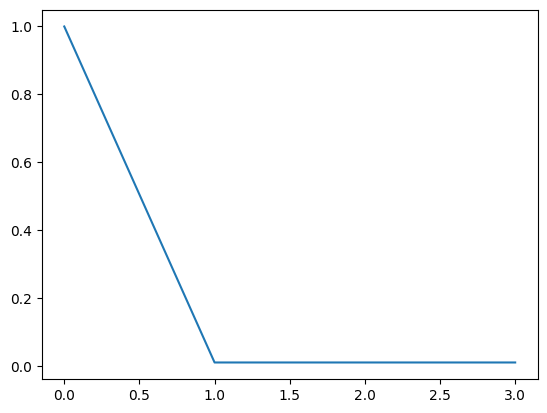

In [580]:
import matplotlib.pyplot as plt

init_epsilon=1.0
min_epsilon=0.01
decay_ratio=0.05
n_episodes=4

eps = []
decay_episodes = max(int(n_episodes * decay_ratio), 1)
delta = (init_epsilon-min_epsilon) / decay_episodes

for e in range(n_episodes):
  if e<=decay_episodes:
    epsilon = init_epsilon - e*delta
    epsilon = np.clip(epsilon, min_epsilon, init_epsilon)
  eps.append(epsilon)

plt.plot(eps)
decay_episodes

(4,
 16,
 array([1.        , 0.21544347, 0.04641589, 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ]))

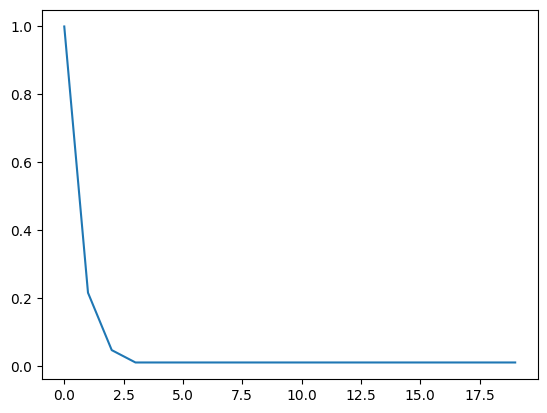

In [581]:
init_epsilon=1.0
min_epsilon=0.01
decay_ratio=0.2
n_episodes=20

decay_episodes = int(n_episodes * decay_ratio)
rem_episodes = n_episodes - decay_episodes

# epsilons = min_epsilon
# epsilons /= np.logspace(np.log10(min_epsilon), np.log10(init_epsilon), decay_episodes)
# epsilons *= init_epsilon - min_epsilon
# epsilons += min_epsilon
epsilons = np.logspace(np.log10(min_epsilon), np.log10(init_epsilon), decay_episodes)[::-1]
epsilons = np.pad(epsilons, (0, rem_episodes), 'edge')

plt.plot(epsilons)
decay_episodes, rem_episodes, epsilons

array([0.01      , 0.04641589, 0.21544347, 1.        ])

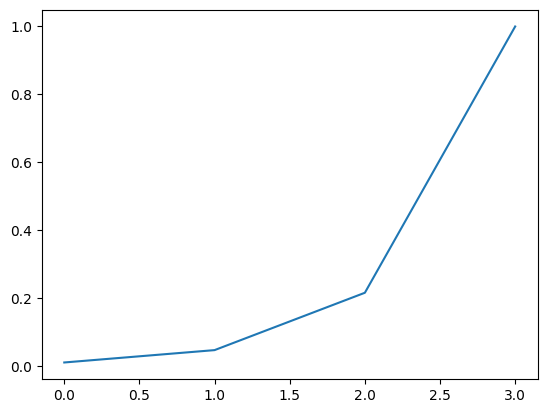

In [582]:
plt.plot(np.logspace(-2, 0, decay_episodes))
np.logspace(-2, 0, decay_episodes)

## Optimistic Init Strategy
Optimistic initialisation strategy: we initialize the Q-function to a high value and act greedily using these estimates.

In [583]:
class OptimisticInitStrategy(StrategyBase):
  def __init__(self, env,
               optimistic_estimate=1.0,
               initial_count=100,
               n_episodes=5000):
    super().__init__(f"Optimistic {optimistic_estimate} {initial_count}",
                     env, n_episodes)
    self.Q = np.full((env.action_space.n), optimistic_estimate, dtype=np.float64)
    self.N = np.full((env.action_space.n), initial_count, dtype=np.float64)

  def run(self):
    for e in tqdm(range(self.n_episodes), desc='Episodes for: {self.name}', leave=True):
      self.update(e, strat="exploit")

## Testing on BSW


Episodes for Pure Exploration: 100%|██████████| 5000/5000 [00:00<00:00, 21199.44it/s]


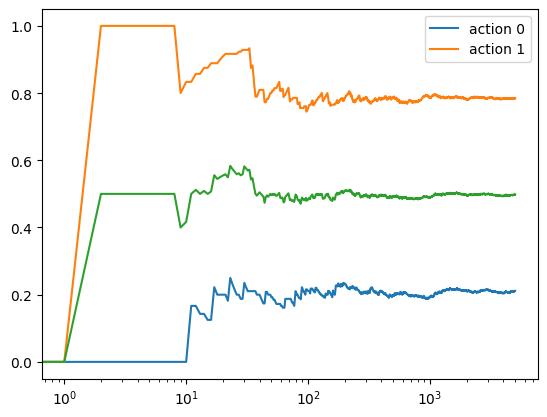

In [584]:
env = gym.make('BanditSlipperyWalk-v0').env
explr = PureExploration(env)
explr.run()
plt.plot(explr.Qe)
plt.plot(explr.Qe.mean(axis=1))
labels = [f'action {i}' for i in range(env.action_space.n)]
plt.legend(labels)
plt.xscale('log')

Episodes for Pure Exploitation: 100%|██████████| 5000/5000 [00:00<00:00, 32983.37it/s]


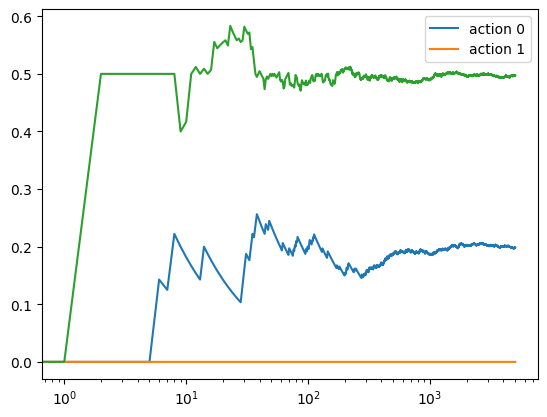

In [585]:
env = gym.make('BanditSlipperyWalk-v0').env
explt = PureExploitation(env)
explt.run()
plt.plot(explt.Qe)
plt.plot(explr.Qe.mean(axis=1))
labels = [f'action {i}' for i in range(env.action_space.n)]
plt.legend(labels)
plt.xscale('log')

Episodes for Epsilon-Greedy 0.01: 100%|██████████| 5000/5000 [00:00<00:00, 31133.12it/s]


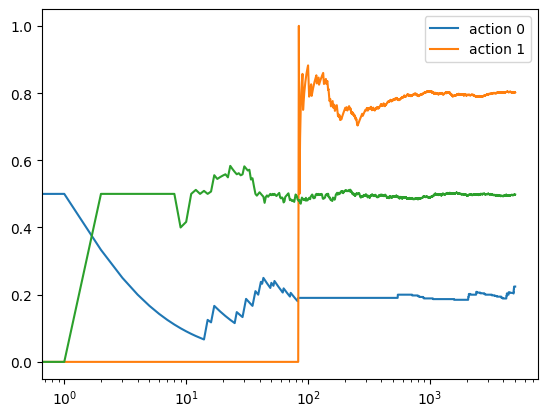

In [586]:
env = gym.make('BanditSlipperyWalk-v0').env
eGreedy = EpsilonGreedy(env)
eGreedy.run()
plt.plot(eGreedy.Qe)
plt.plot(explr.Qe.mean(axis=1))
labels = [f'action {i}' for i in range(env.action_space.n)]
plt.legend(labels)
plt.xscale('log')

Episodes for: Lin e-greed 1.0 0.01 0.05: 100%|██████████| 5000/5000 [00:00<00:00, 27291.78it/s]


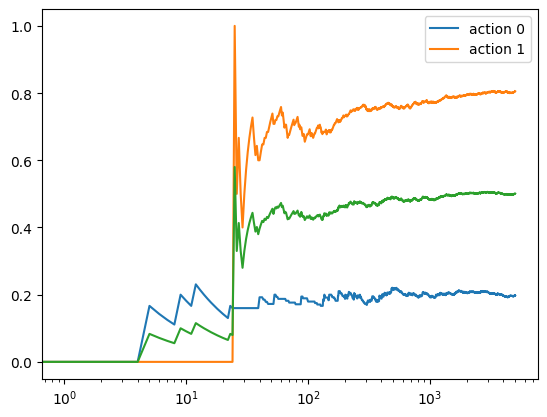

In [587]:
env = gym.make('BanditSlipperyWalk-v0').env
eLinGreedy = LinearDecayEpsilonGreedy(env)
eLinGreedy.run()
plt.plot(eLinGreedy.Qe)
plt.plot(eLinGreedy.Qe.mean(axis=1))
labels = [f'action {i}' for i in range(env.action_space.n)]
plt.legend(labels)
plt.xscale('log')

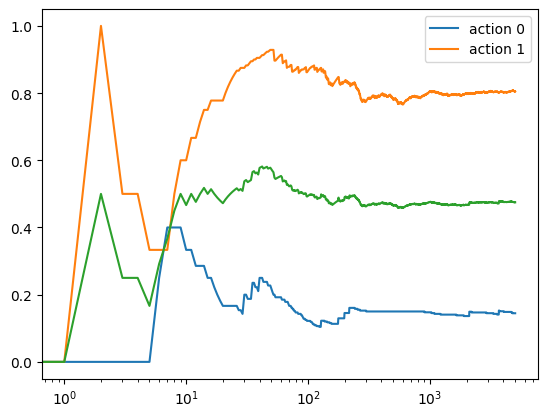

In [588]:
env = gym.make('BanditSlipperyWalk-v0').env
eExpGreedy = ExponentialDecayEpsilonGreedy(env)
eExpGreedy.run()
plt.plot(eExpGreedy.Qe)
plt.plot(eExpGreedy.Qe.mean(axis=1))
labels = [f'action {i}' for i in range(env.action_space.n)]
plt.legend(labels)
plt.xscale('log')

Episodes for: {self.name}: 100%|██████████| 5000/5000 [00:00<00:00, 20521.95it/s]


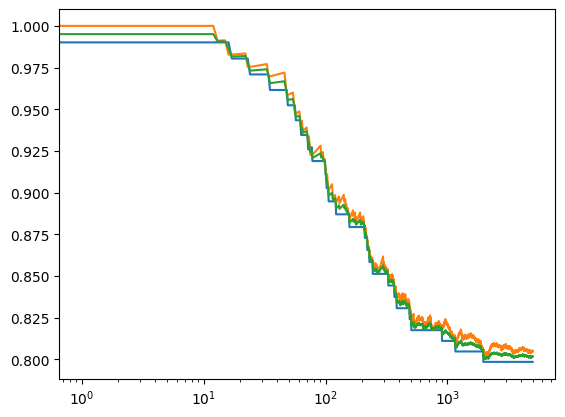

In [589]:
env = gym.make('BanditSlipperyWalk-v0').env

optim_strat = OptimisticInitStrategy(env)
optim_strat.run()
plt.plot(optim_strat.Qe)
plt.plot(optim_strat.Qe.mean(axis=1))
# labels = [f'action {i}' for i in range(env.action_space.n)]
# plt.legend(labels)
plt.xscale('log')

Text(0.5, 1.0, 'Mean Episode Reward')

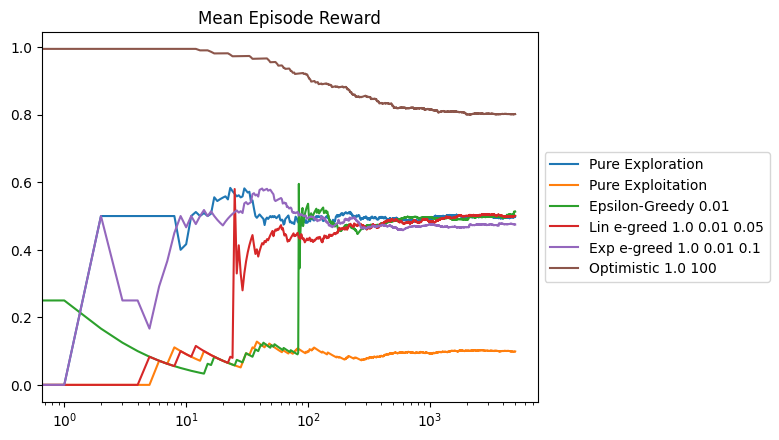

In [590]:
strategies = [explr, explt, eGreedy, eLinGreedy, eExpGreedy, optim_strat]
for strat in strategies:
  plt.plot(strat.Qe.mean(axis=1))
#plt.plot(np.array([strat.Qe.mean(axis=1) for strat in strategies]).reshape(6, 5000))
plt.xscale('log')
labels = [f'{strat.name}' for strat in strategies ]
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Mean Episode Reward')


Text(0.5, 1.0, 'Total Regret')

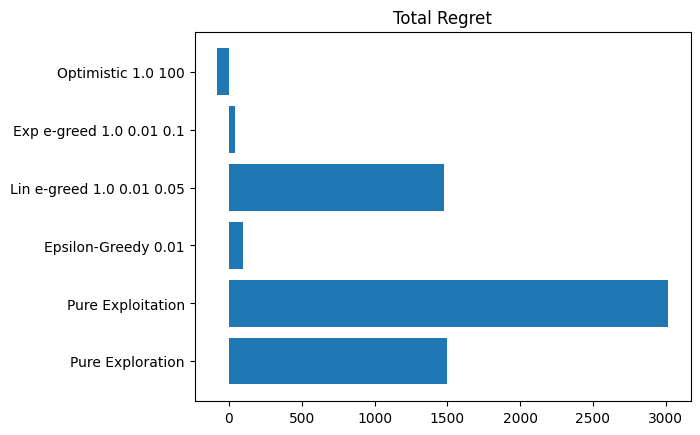

In [591]:
strategies = [explr, explt, eGreedy, eLinGreedy, eExpGreedy, optim_strat]
labs = [strat.name for strat in strategies]
trs = [strat.total_regret()[4999] for strat in strategies]

plt.barh(labs, trs)
plt.title('Total Regret')

Text(0.5, 1.0, 'Total Regret')

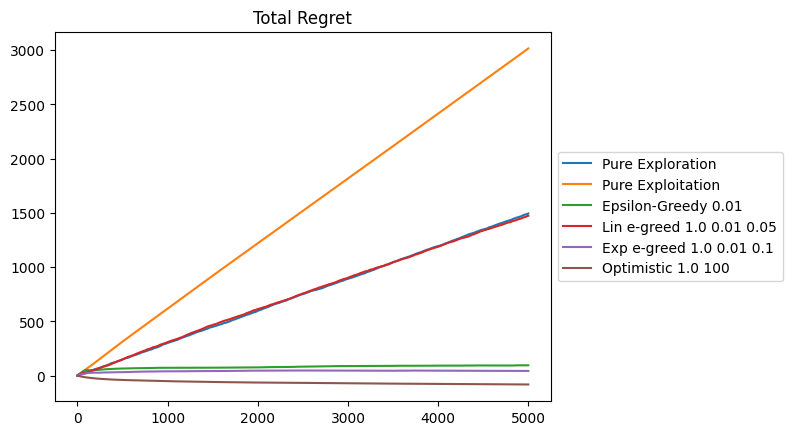

In [592]:
strategies = [explr, explt, eGreedy, eLinGreedy, eExpGreedy, optim_strat]
for strat in strategies:
  plt.plot(strat.total_regret())
labels = [f'{strat.name}' for strat in strategies ]
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Total Regret')